# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [5]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [7]:
import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torchtext
from torchtext.data.utils import get_tokenizer
import seaborn as sns
sns.set(palette="Set2")
sns.set_style("whitegrid")
import nltk
nltk.download("stopwords")
import os

device = "cuda"
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
print(device)

cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/akruglov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 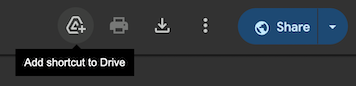

In [3]:
# from google.colab import drive  # в итоге запускал в другом месте
# drive.mount('/content/drive/')

Скачаем данные для обучения и тестирования:

In [4]:
# dataset = pd.read_csv('/content/drive/MyDrive/salary_dataset.csv')
dataset = pd.read_csv('salary_dataset.csv')
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [5]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [6]:
tokenizer = get_tokenizer("spacy", language="en_core_web_sm") # Зададим токенизаторы
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [7]:
counter = Counter()
for text in tqdm(dataset["FullDescription"]):  # посчитаем количество вхождений каждого токена
    counter.update(token for token in tokenizer(text) if token not in stop_words and token not in punc)

ordered_dict = OrderedDict(counter)
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

100%|██████████████████████████████████████████████████████████████████████████| 200000/200000 [05:26<00:00, 611.76it/s]


Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [8]:
list(ordered_dict.items())[:10]

[(' ', 666725),
 ('experience', 269289),
 ('The', 258645),
 ('role', 211475),
 ('work', 207318),
 ('team', 194087),
 ('This', 180149),
 ('within', 175173),
 ('You', 173743),
 ('skills', 162215)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [9]:
vocab = torchtext.vocab.vocab(ordered_dict)  # зададим словарь
unk_token, pad_token = "<unk>", "<pad>"

def add_special_tokens(vocab):
    """Добавление специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX

vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [10]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры:
        texts (list) — корпус токенизированных текстов, на котором будет происходить обучение
        labels (list) — истинные метки текстов
        """
        self.texts, self.target = texts, target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [11]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до max длины в батче с UNK_IDX
    Вход:
    * batch — батч с текстами и таргетами
    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, targets = zip(*batch)
    texts_tensors = [torch.LongTensor(np.array(t)) for t in texts]  # сформируем тензоры
    targets = torch.DoubleTensor(np.array(targets))
    texts_tensors = pad_sequence(texts_tensors, padding_value=PAD_IDX_EN, batch_first=True)  # до max длины в батче
    return texts_tensors, targets

Токенизируем текст, а таргет переведем во `float`.

In [12]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [13]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  6, 25000, 25000, 142, 18, 25000, 25000, 3604, 25000, 35, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  67, 12, 25000, 14, 25000, 25000, 4672, 393, 871, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  573, 186, 1516, 658, 0, 24442, 25000, 15724, 13306, 87, ...
Таргет: 72098.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [14]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(tokens, target)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)

(150000, 50000)

Посмотрим на отмасштабированные значения зарплаты:

In [15]:
print("Преобразованные таргеты:\n" + ", ".join([str(round(t.item(), 4)) for t in train_data[:3][1]]) + ", ...")

Преобразованные таргеты:
0.1026, 0.1231, 0.1026, ...


Сформируйте даталоадеры для обучения и валидации.

In [16]:
BATCH_SIZE = 1024  #64
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

По сути, ничего менять и не нужно. После линейного слоя и так не применяась сигмоида (внутри метода forward), только теперь линейный слой выполняет роль регрессора. Сырой выход линейного слоя и есть искомый предикт

In [17]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(self, num_tokens, emb_size=512, rnn_num_units=64, output_dim=1):
        """
        num_tokens — общее количество токенов,
        emb_size — размер эмбеддингового пространства,
        rnn_num_units - размер пространства скрытых представлений в rnn,
        output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.regressor = nn.Linear(rnn_num_units, output_dim)

    def forward(self, x):
        """
        Параметр: x - общее количество токенов, x.shape = (batch_size, max_pad_len)
        Возвращает: predictions - предсказания модели.
        """
        emb = self.emb(x)  # Получим эмбеддинги для входов: (batch_size, max_pad_len, emb_size)
        # Прогоним через RNN-сеть и получим скрытое состояние, где хранится информация о послед.-ти: (batch_size, rnn_num_units)
        _, (h_state, _) = self.rnn(emb)
        # Прогоним через полносвязный слой и получим предикты для каждого токена: (batch_size, num_tokens)
        predictions = self.regressor(h_state.squeeze(0))
        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [18]:
def mse(preds, y):
    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [19]:
def train(model, iterator, optimizer, criterion, loss_history):
    """1 эпоха обучения модели и подсчёта её точности"""
    epoch_loss, epoch_metric = 0, 0
    
    model = nn.DataParallel(model, device_ids=[0,1,2,3]) # мульти-гпу для ускорения

    model.train()
    for batch_id, batch in enumerate(iterator):
        optimizer.zero_grad()
        texts, targets = [elem.to(device) for elem in batch]
        targets = targets[:,0].float()
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, targets)
        metric = mse(predictions, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_metric += metric.item()
        loss_history.append(loss.item())
    return epoch_loss / len(iterator), epoch_metric / len(iterator)

def evaluate(model, iterator, criterion, loss_history):
    """1 эпоха тестирования модели и подсчёта её точности"""
    epoch_loss, epoch_metric = 0, 0
    model.eval()
    with torch.no_grad():
        for batch_id, batch in enumerate(iterator):
            texts, targets = [elem.to(device) for elem in batch]
            targets = targets[:,0].float()
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, targets)
            metric = mse(predictions, targets)
            epoch_loss += loss.item()
            epoch_metric += metric.item()
            loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_metric / len(iterator)

def epoch_time(start_time, end_time):
    """Подсчёт времени работы одной эпохи"""
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [20]:
def training_loop(model_instance, optimizer, criterion, n_epochs=10):
    """Обучение нейронной сети"""
    best_valid_loss = float("inf")
    loss_history, val_loss_history, metric_history, val_metric_history = [],[],[],[]
    for epoch in tqdm(range(n_epochs)):
        start_time = time.time()
        train_loss, train_metric = train(model_instance, train_loader, optimizer, criterion, loss_history)
        metric_history.append(train_metric)
        valid_loss, valid_metric = evaluate(model_instance, valid_loader, criterion, val_loss_history)
        val_metric_history.append(valid_metric)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Отобразим графики loss'ов
        clear_output(True)
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.plot(loss_history)
        plt.title("Train Loss")
        plt.xlabel("Батч")
        plt.subplot(1, 3, 2)
        plt.plot(val_loss_history, color="tab:orange")
        plt.title("Valid Loss")
        plt.xlabel("Батч")
        if valid_loss < best_valid_loss:  # Если значение функции потерь улучшилось, сохраним параметры модели
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Отрисуем значение метрики от эпохи
        plt.subplot(1, 3, 3)
        plt.plot(metric_history, label="Train")
        plt.plot(val_metric_history, label="Valid")
        plt.legend()
        plt.title("Метрика (MSE)")
        plt.xlabel("Эпоха")
        plt.show()

        print(f"Эпоха: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s")

In [21]:
history = []
model1 = SimpleRNNRegressor(num_tokens=num_tokens, emb_size=100, rnn_num_units=256, output_dim=1).to(device)
criterion = nn.MSELoss()  # У нас задача регрессии, будем использовать MSELoss
optimizer = torch.optim.Adam(model1.parameters(), lr=0.005)
model1

SimpleRNNRegressor(
  (emb): Embedding(25002, 100, padding_idx=25001)
  (rnn): LSTM(100, 256, batch_first=True)
  (regressor): Linear(in_features=256, out_features=1, bias=True)
)

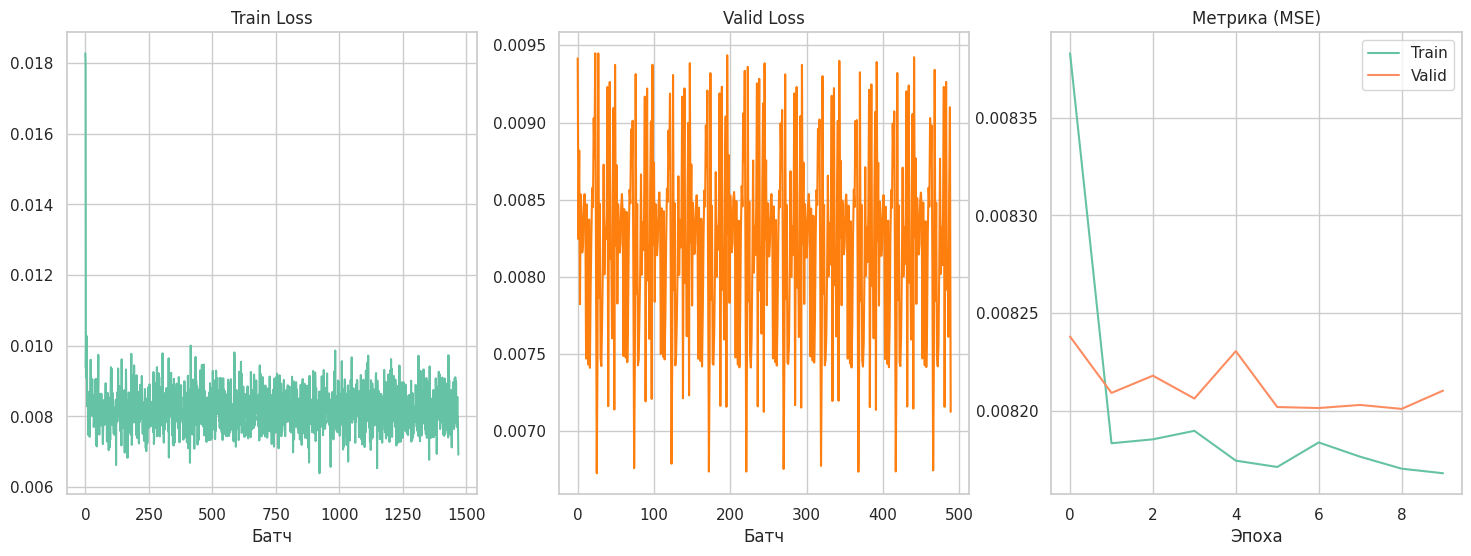

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [04:35<00:00, 27.51s/it]

Эпоха: 10 | Время обучения эпохи: 0m 25s


In [22]:
training_loop(model1, optimizer, criterion)

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

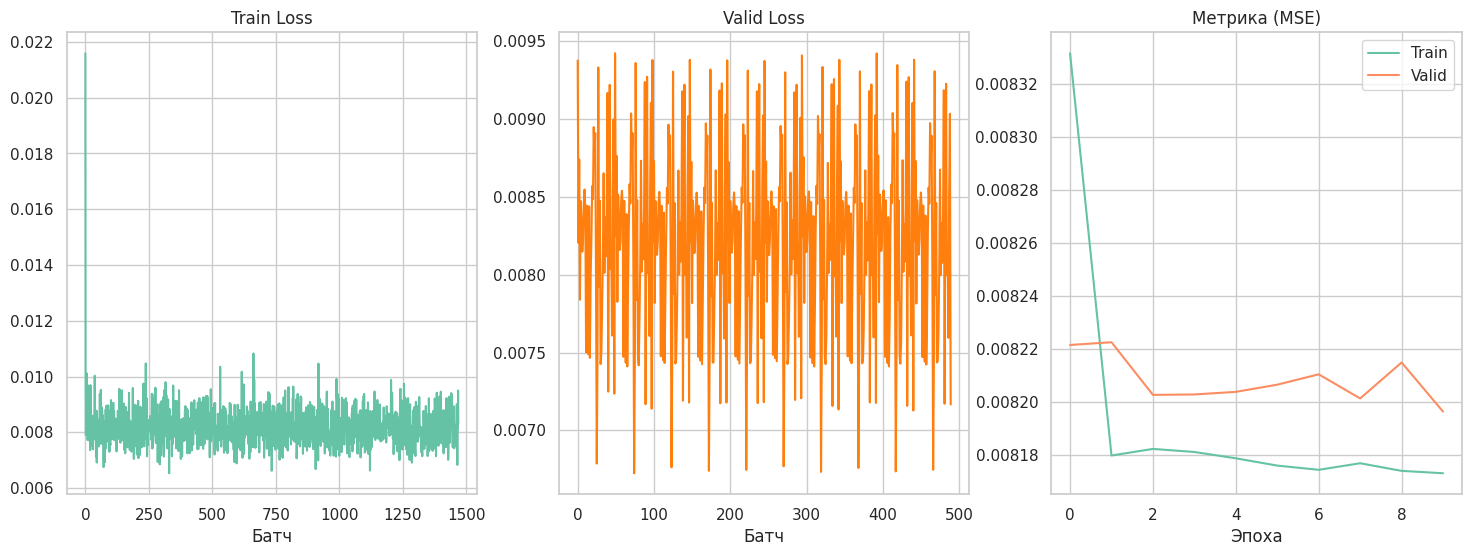

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [04:19<00:00, 25.94s/it]

Эпоха: 10 | Время обучения эпохи: 0m 26s


In [23]:
history = []
model2 = SimpleRNNRegressor(num_tokens=num_tokens, emb_size=64, rnn_num_units=256, output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.005)
training_loop(model2, optimizer, criterion)

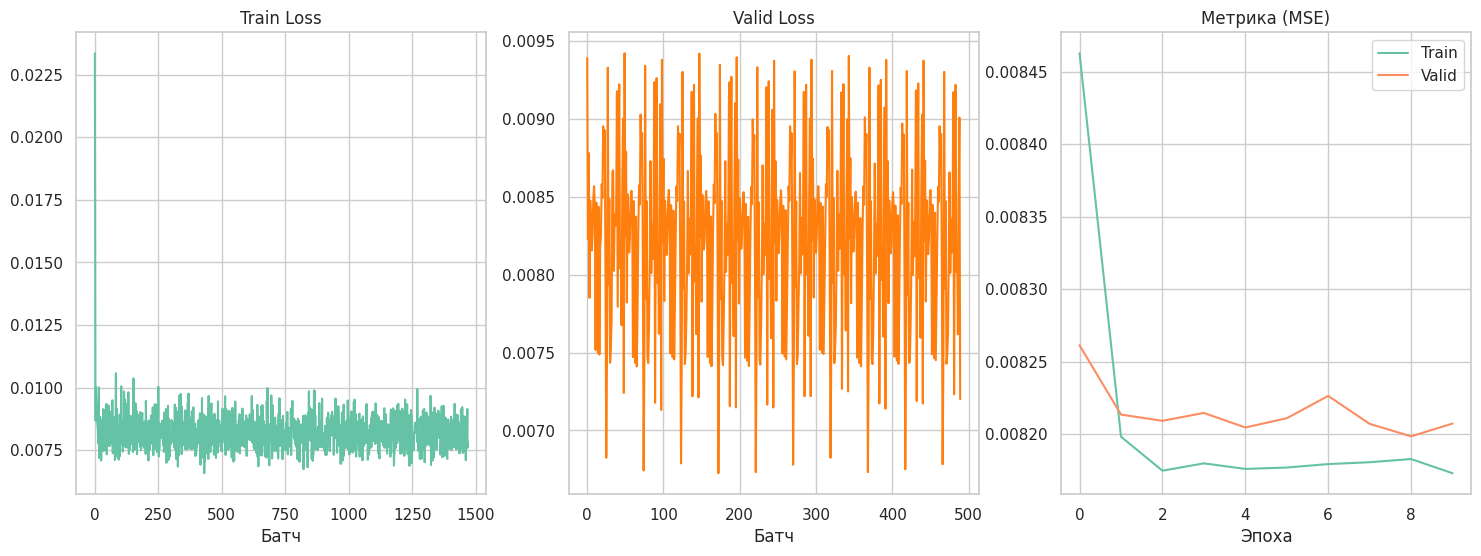

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [04:36<00:00, 27.68s/it]

Эпоха: 10 | Время обучения эпохи: 0m 27s


In [24]:
history = []
model3 = SimpleRNNRegressor(num_tokens=num_tokens, emb_size=256, rnn_num_units=256, output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.005)
training_loop(model3, optimizer, criterion)

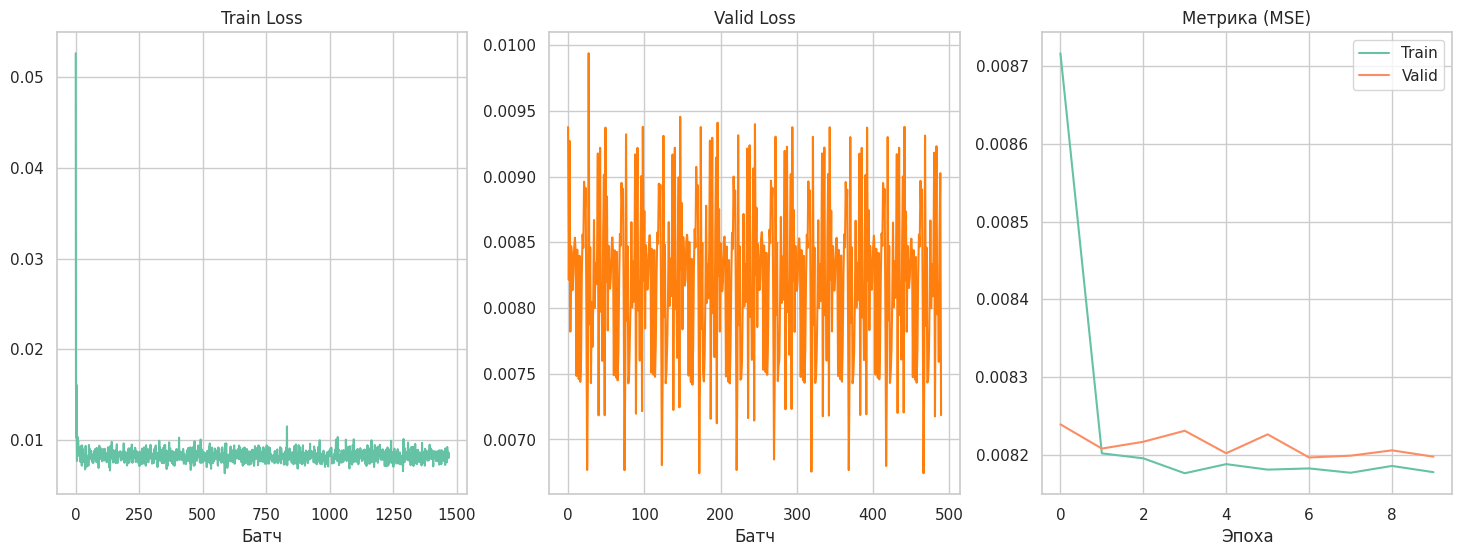

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.84s/it]

Эпоха: 10 | Время обучения эпохи: 0m 21s


In [25]:
history = []
model4 = SimpleRNNRegressor(num_tokens=num_tokens, emb_size=100, rnn_num_units=128, output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.005)
training_loop(model4, optimizer, criterion)

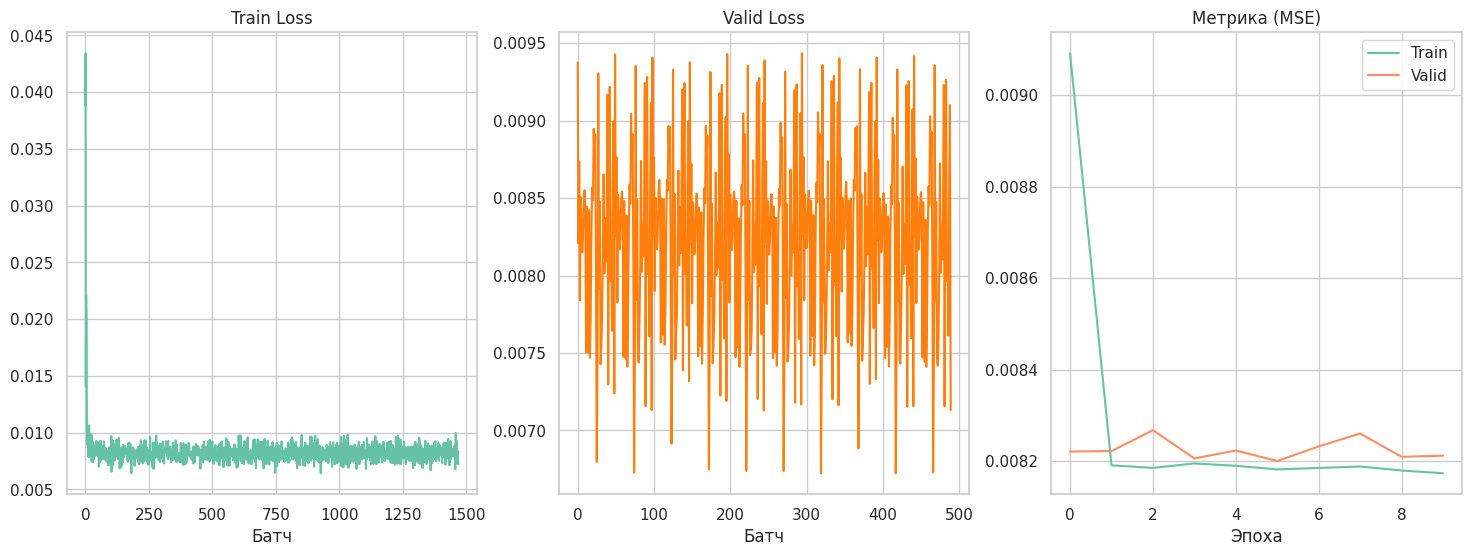

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [05:29<00:00, 32.96s/it]

Эпоха: 10 | Время обучения эпохи: 0m 31s


In [26]:
history = []
model5 = SimpleRNNRegressor(num_tokens=num_tokens, emb_size=100, rnn_num_units=512, output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=0.005)
training_loop(model5, optimizer, criterion)

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

In [35]:
data_batch, labels_batch = next(iter(valid_loader))
with torch.no_grad():
    preds = model1(data_batch.to(device))

indices = torch.randint(low=0, high=len(data_batch), size=(5,))  # для 5 случайных примеров из тест. батча
for idx in indices:
    print("-" * 20)
    print("Text:")
    print(" ".join([token for token in vocab.lookup_tokens(data_batch[idx].tolist()) if token not in ["<unk>", "<pad>"]]))
    print(f"True target: {round(scaler.inverse_transform(np.array([[labels_batch[idx].item()]])).item(), 2)}")
    print(f"Pred target: {round(scaler.inverse_transform(np.array([[preds[idx].item()]])).item(), 2)}")
    print()

--------------------
Text:
Are looking next move Gas Engineering career An excellent position arisen join prestigious Facilities Management company Maintenance Engineer The client requires candidates Fife Edinburgh locations carry maintenance coverage across Central Scotland Dundee You background Gas Installation Servicing Maintenance Repair Candidates required excellent communication skills role client facing attending customer sites This role report directly Contracts Manager require candidates direct liaison management client Essential qualification Maintenance Engineering position Commercial Gas Safe Domestic Gas Safe Testing Candidates following also highly desirable 17th Edition This fantastic opportunity right individual progress career enter solid organisation As mobile role driving licence essential This permanent Maintenance Engineer role covering Central Scotland comes hourly rate /hour hr week Please send CV today RECRUITING NOW This job originally posted
True target: 28800

In [ ]:
assert False

**Вывод:**  
В рамках задачи удалось познакомитсья с NLP и решить задачу регрессии: обучить модель (рекуррентную нейросеть), предсказывающую зарплату по описанию вакансии. По полученным графикам не получилось с уверенностью установить, как варьирование параметров влияет на качество модели, т.к. во всех случаях алгоритм сошелся примерно к одному и тому же результату.  
Ключевой вывод, который можно сделать: модели в NLP как правило очень тяжелые и обучаются крайне долго. Распараллеливание помогло кратно ускорить обучение, но догадываюсь, что в реальной практике необходимо обучаться на гигантских датасетах, а значит, все равно обучение будет проходить долго. Удивительно, что такая задача интуитивно кажется человеку очень легкой (как и многие другие задачи машинного обучения, яркий пример - классификация изображений), но компьютеру требуется много ресурсов.  

---
### Задача 2. Использование большой языковой модели


Ваша задача &mdash; применить <a target="_blank" href="https://llama-2.ai/">Llama 2</a> к предыдущей задаче и заставить ее предсказать заработную плату по текстовому описанию. Существует мало русскоязычных моделей, способных решить такую задачу и помещающихся в <a target="_blank" href="https://colab.research.google.com/">Colab</a>, поэтому вам придется писать запросы на английском!

In [8]:
# !pip3 install -q bitsandbytes==0.41.1 transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2  > null
import transformers
import bitsandbytes as bnb
assert torch.cuda.is_available(), "для этой части понадобится GPU"

Дисклеймер: *использовать LLM в рамках ограничений Colab хоть и возможно, но очень трудно.*

> Так как процесс генерации очень хрупкий и может сломаться при любом неверном движении, мы настоятельно рекомендуем **сохранить результаты предыдущего задания в отдельном файле** и приступать к этой задаче в самом конце. Решения задач можно сдавать в бот разными файлами.

> Если у вас возникла ошибка `Out of memory`, перезапустите ноутбук и попробуйте снова. Да, языковые модели без своей GPU &mdash; это тяжело...





От вас требуется подобрать такой промпт, который приводил бы к нужному выводу модели. Можете экспериментировать с параметрами генерации, список которых можно посмотреть в <a target="_blank" href="https://github.com/huggingface/transformers/blob/c4d4e8bdbd25d9463d41de6398940329c89b7fb6/src/transformers/generation_utils.py#L101">исходнике</a>.

Существуют различные техники, которые могут помочь вам "разговорить" языковую модель. О многих из них вы сможете прочитать <a target="_blank" href="https://docs.mistral.ai/guides/prompting-capabilities/">здесь</a>. В нашем случае полезным может быть метод Few-Shot Learning, который заключается в предоставлении модели нескольких примеров.

In [28]:
model_name = "TheBloke/Llama-2-13B-GPTQ"  # Загружаем Llama токенизатор и саму модель Llama
tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
)

Прогоним ровно на тех же примерах из конца 1й задачи, чтобы было с чем сравнивать

In [29]:
descriptions = [
    'Are looking next move Gas Engineering career An excellent position arisen join prestigious Facilities Management company Maintenance Engineer The client requires candidates Fife Edinburgh locations carry maintenance coverage across Central Scotland Dundee You background Gas Installation Servicing Maintenance Repair Candidates required excellent communication skills role client facing attending customer sites This role report directly Contracts Manager require candidates direct liaison management client Essential qualification Maintenance Engineering position Commercial Gas Safe Domestic Gas Safe Testing Candidates following also highly desirable 17th Edition This fantastic opportunity right individual progress career enter solid organisation As mobile role driving licence essential This permanent Maintenance Engineer role covering Central Scotland comes hourly rate /hour hr week Please send CV today RECRUITING NOW This job originally posted',
    'Our client plus bedroom top end luxury star hotel substantial food beverage outlets An individual possesses background large scale operations able manage motivate lead big team required join management modern stylish hotel operation You innovative approach expected challenge existing methods carrying tasks The remit covers busy food drink outlets employ staff per day It include banqueting Reporting Food Beverage Director essential successful candidate progressive experience volume catering operations operating top end market ambitious develop career upwards top end hotel operations OTE /****k',
    'Experienced Accounts Administrator required reputable company based Somerset This initially offered years contract possibility extension 14 months This full time position working either 8.30am   4 pm 9   5 pm Monday Friday salary   PA DOE Seeking experienced Accounts Administrator join dynamic friendly highly successful organisation Duties role include   Ensuring customer delivery paid time   Processing payments   Reconciling supplier statements Purchase Ledger   Sales Ledger   Sending remittance general suppliers   Issuing reconciling petty cash   Processing sales invoices   Some payroll duties   Ad hoc duties support team The successful applicant competent user computerised accounts software Microsoft Word Excel ability work deadlines good accuracy skills To apply role please online contact Office Angels equal opportunities employer This job originally posted',
    'FINTEC recruit seeking electrical Designer projects This working client defence sector Experience ship essential Immediate start Experience GRP Composite structures You must possess MS office skills Applicants must security clearance possible application C',
    'The ideal candidate mechanical engineering background preferably project engineering CAD design experience Computer literate good working knowledge word excel Excellent communication skills imperative The working hours Mon   Fri 9 acting Employment Agency relation vacancy'
]
true_targets = [28800.0, 35000.0, 16000.0, 42240.0, 40000.0]  # скопировал

Я слышал, что использование в промпте вежливых слов вроде "please" и оборотов наподобие "it is important for my work" повышает качество работы генеративных текстовых моделей. Это явление можно объяснить тем, что такие модели (особенно, чат-боты) могут обучаться на человеческих переписках, в которых вежливость и апелляция к важности задачи помогают добиться желаемого ответа от собеседника. Однако, в этой задаче у меня такой подход не сработал (хотя он работал с другими моделями в режиме чат-бота)  

Следующий подход, который я поробовал, заключался в том, чтобы стилизовать аутпут под объявление о вакансии. Далее модель использовалась, чтобы дополнить объявление информацией о зарплате. Это уже сработало лучше  

In [44]:
for desc, target in zip(descriptions, true_targets):
    prompt = f"NOW HIRING! JOB DESCRIPTION:\n'{desc[:500]}...'\nSALARY in $:"  # после 'SALARY in $' будет предикт модели
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    generate_ids = model.generate(inputs.input_ids, max_length=136)
    print(tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0])
    print(f'True target: {target}\n--------------------')

NOW HIRING! JOB DESCRIPTION:
'Are looking next move Gas Engineering career An excellent position arisen join prestigious Facilities Management company Maintenance Engineer The client requires candidates Fife Edinburgh locations carry maintenance coverage across Central Scotland Dundee You background Gas Installation Servicing Maintenance Repair Candidates required excellent communication skills role client facing attending customer sites This role report directly Contracts Manager require candidates direct liaison management...'
SALARY in $: 30000 - 35000
SALARY in £: 20000 - 2
True target: 28800.0
--------------------
NOW HIRING! JOB DESCRIPTION:
'Our client plus bedroom top end luxury star hotel substantial food beverage outlets An individual possesses background large scale operations able manage motivate lead big team required join management modern stylish hotel operation You innovative approach expected challenge existing methods carrying tasks The remit covers busy food drink ou

Если почувствуете, что у вас не получается добиться от модели желаемого, вы можете попробовать воспользоваться любой другой языковой моделью на ваш выбор, но тогда вы получите **не больше 30 баллов**.

В случае использования другой модели предоставьте скриншот ответа LLM и промпт, который вы использовали (в текстовом формате). Его можно вставить прямо в ноутбук или прислать в бот отдельным файлом.

**Вывод:**  
В рамках задачи удалось подобрать промпт, с помощью которого модель выдает более-менее осмысленный ответ. Использовать такой подход на практике, однако, рискованно (качество низкое, работа нестабильная). По-моему, лучше воспользоваться моделью из первой задачи.   
Большие языковые модели настолько сложно устроены, что даже для того, чтобы использовать их, необходимо овладеть искусством промпт-инжиниринга. Интересно, что пока что непонятно, как подбирать оптимальный промпт: иногда выигрывают совершенно удивительные стратегии  

---
*Если хотите отточить навык написания промптов &mdash; **prompt-engineering** &mdash; можете попробовать сыграть в <a target="_blank" href="https://gandalf.lakera.ai/">игру</a>. В ней нужно заставить Гендальфа выдать пароль. Со временем уровни становятся все сложнее и требуют более хитрых приемов.*